In [ ]:
!pip install git+https://github.com/cheind/py-motmetrics.git
import motmetrics as mm

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import requests
import zipfile
import os
import pandas as pd
import time

In [3]:
import numpy as np
import pickle
import zlib

def decompress_np_img_zlib(compressed_data):
    shape_info, compressed_img = pickle.loads(compressed_data)
    decompressed_bytes = zlib.decompress(compressed_img)
    decompressed_img = np.frombuffer(decompressed_bytes, dtype=np.uint16)
    decompressed_img = decompressed_img.reshape(shape_info)
    return decompressed_img

In [4]:
def download_file(url, output_path):
    """
    Download a file from a given URL and save it to the specified output path.

    Args:
    url (str): The URL of the file to download.
    output_path (str): The path where the file will be saved.
    """
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(output_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
        print(f"Downloaded {output_path}")
    else:
        print(f"Failed to download {output_path}, status code: {response.status_code}")

In [ ]:
!wget /path/to/GeneralSymmetricTracking_AllSamplesFramewise.pkl
AllSampleFramewise = pd.read_pickle("GeneralSymmetricTracking_AllSamplesFramewise.pkl")

In [6]:
AllSampleFramewise = AllSampleFramewise[AllSampleFramewise["ValidSample"] == True]

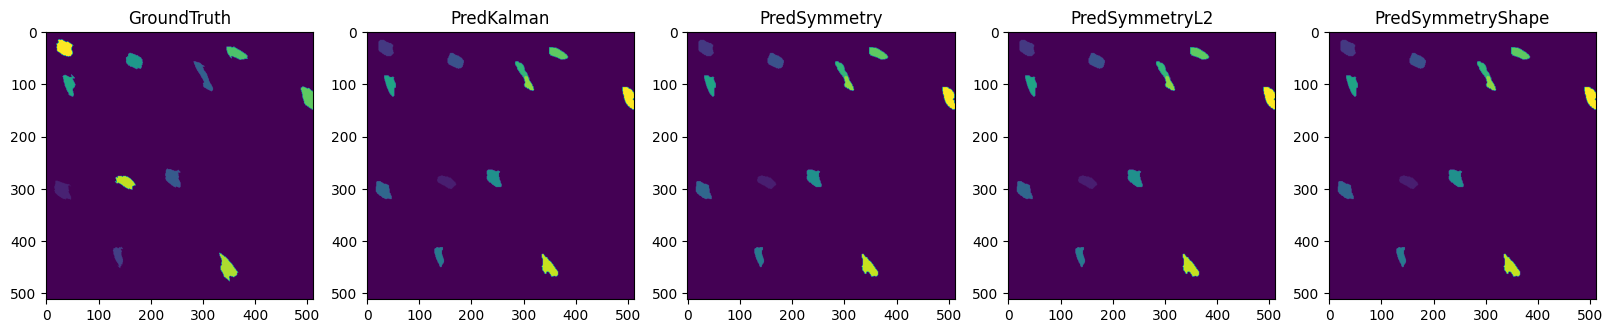

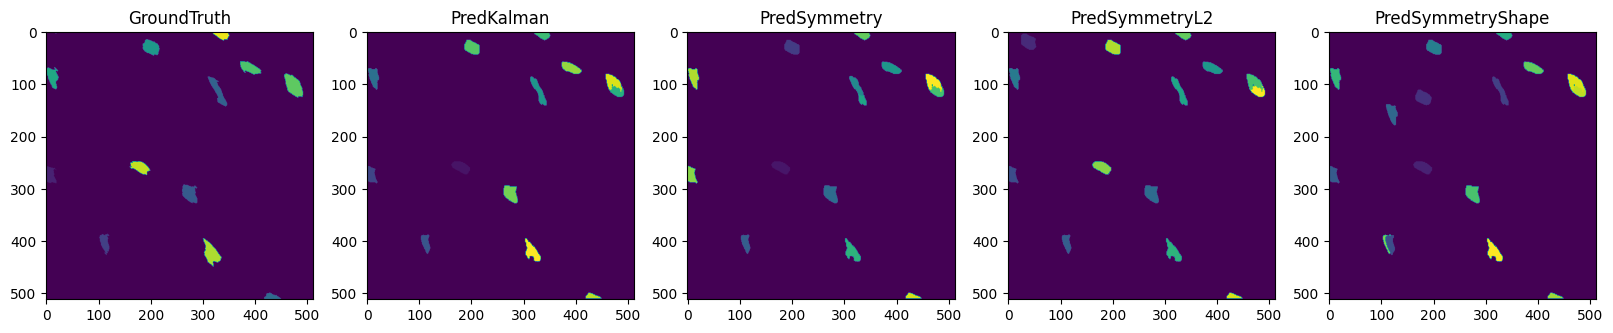

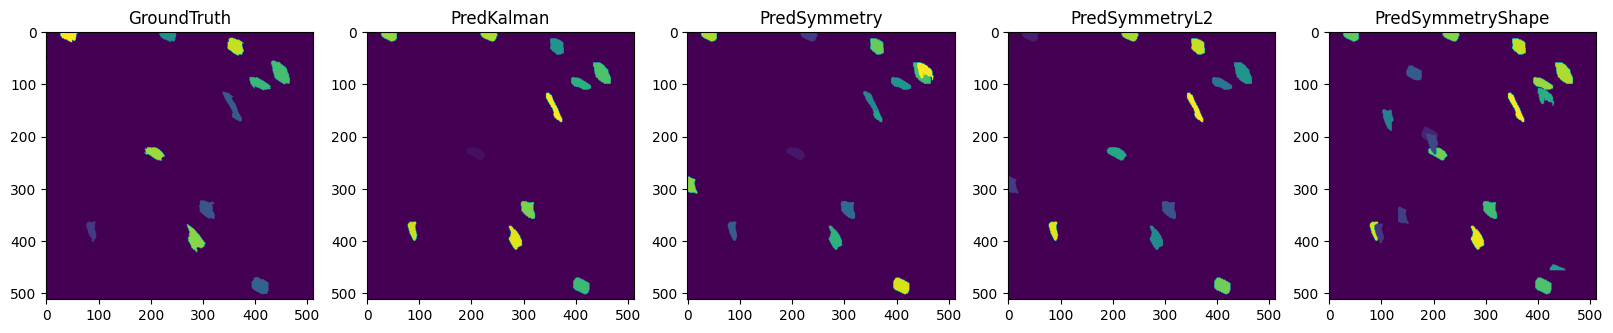

In [7]:
#TestSample = AllSampleFramewise.query("Dataset == 'ArrowSynthTurns' and SampleID == '081'")
TestSample = AllSampleFramewise.query("Dataset == 'ArrowSynthShapes' and SampleID == '081'")

for frame, frame_sr in TestSample.head(3).iterrows():

    fig, axs = plt.subplots(1, 5, figsize=(20, 5))

    for predictor, i in zip(["GroundTruth", "PredKalman", "PredSymmetry", "PredSymmetryL2", "PredSymmetryShape"], range(5)):
        axs[i].imshow(decompress_np_img_zlib(frame_sr[predictor]))
        axs[i].set_title(predictor)
    plt.show()



# IoU50 metrics

In [8]:
def calculate_iou(gt_mask, pred_mask):
    intersection = np.logical_and(gt_mask, pred_mask).sum()
    union = np.logical_or(gt_mask, pred_mask).sum()
    if union == 0:
        return 0

    iou = intersection / union
    return iou

In [ ]:
#@title tr and seg f-scores broken up

def calculate_segmentation_fscore(gt_mask, pred_mask):
    # Extract instance IDs from both GroundTruth and PredKalman
    gt_ids = np.unique(gt_mask)
    pred_ids = np.unique(pred_mask)

    # Calculate IoU for each pair of instances
    iou_results = []

    true_positive_count = 0

    for gt_id in gt_ids:

        found_assigmnet = False

        if gt_id == 0:
            continue  # Skip background if it's labeled as 0
        gt_instance_mask = (gt_mask == gt_id).astype(np.uint8)

        for pred_id in pred_ids:
            if pred_id == 0:
                continue  # Skip background if it's labeled as 0
            pred_instance_mask = (pred_mask == pred_id).astype(np.uint8)

            iou = calculate_iou(gt_instance_mask, pred_instance_mask)
            if iou > 0.5:
                iou_results.append((gt_id, pred_id, iou))
                found_assigmnet = True
                break
            #iou_results.append((gt_id, pred_id, iou))

        if found_assigmnet:
            true_positive_count += 1

    # Calculate false positives and false negatives
    false_positives_count = len(pred_ids) - true_positive_count
    false_negatives_count = len(gt_ids) - true_positive_count

    # Calculate f-score
    precision = true_positive_count / (true_positive_count + false_positives_count)
    recall = true_positive_count / (true_positive_count + false_negatives_count)
    if precision + recall == 0:
        return 0
    f_score = 2 * (precision * recall) / (precision + recall)

    return f_score

def calculate_tracking_fscore(gt_mask_0, gt_mask_1, pred_mask_0, pred_mask_1):

    # Extract instance IDs from both GroundTruth and PredKalman
    gt_ids = np.unique(gt_mask_0)
    pred_ids = np.unique(pred_mask_0)

    true_positive_count = 0

    for gt_id in gt_ids:

        found_assigmnet = False

        if gt_id == 0:
            continue  # Skip background if it's labeled as 0
        gt_instance_mask = (gt_mask_0 == gt_id).astype(np.uint8)

        for pred_id in pred_ids:
            if pred_id == 0:
                continue  # Skip background if it's labeled as 0
            pred_instance_mask = (pred_mask_0 == pred_id).astype(np.uint8)

            iou_0 = calculate_iou(gt_instance_mask, pred_instance_mask)
            if iou_0 > 0.5:
                gt_instance_mask_1 = (gt_mask_1 == gt_id).astype(np.uint8)
                pred_instance_mask_1 = (pred_mask_1 == pred_id).astype(np.uint8)
                iou_1 = calculate_iou(gt_instance_mask_1, pred_instance_mask_1)
                if iou_1 > 0.5:
                    found_assigmnet = True
                    break

        if found_assigmnet:
            true_positive_count += 1

    # Calculate false positives and false negatives
    false_positives_count = len(pred_ids) - true_positive_count
    false_negatives_count = len(gt_ids) - true_positive_count

    # Calculate f-score
    precision = true_positive_count / (true_positive_count + false_positives_count)
    recall = true_positive_count / (true_positive_count + false_negatives_count)
    if precision + recall == 0:
        return 0
    f_score = 2 * (precision * recall) / (precision + recall)

    return f_score


def calculate_semantic_segmentation_iou(gt_mask, pred_mask):
    gt_objects = gt_mask > 0
    pred_objects = pred_mask > 0
    return calculate_iou(gt_objects, pred_objects)

In [ ]:
#@title Region tracking scores (slow to calculate, might not be usable) - Gergő

try:
  import cupy as cp
except:
  pass

def val_counts(arr):
    counts = np.bincount(arr)
    return counts, np.nonzero(counts)[0]

def calculate_region_tracking_pred_accuracy_cpu(gt_mask_0, gt_mask_1, pred_mask_0, pred_mask_1):
    pred_ids = np.unique(pred_mask_0)
    pred_ids = pred_ids[pred_ids != 0]

    true_positive_count = 0

    for pred_id in pred_ids:

      pred_instance_mask_0 = (pred_mask_0 == pred_id).astype(np.uint8)
      pred_instance_mask_1 = (pred_mask_1 == pred_id).astype(np.uint8)

      # Select ground truth region where prediction istance mask is
      gt_region_mask_0 = gt_mask_0[pred_instance_mask_0]
      gt_region_mask_1 = gt_mask_1[pred_instance_mask_1]

      # Count unique values and their counts in the region

      gt_region_mask_0 = gt_region_mask_0.ravel()
      gt_region_mask_0 = gt_region_mask_0[gt_region_mask_0 != 0]
      gt_region_mask_1 = gt_region_mask_1.ravel()
      gt_region_mask_1 = gt_region_mask_1[gt_region_mask_1 != 0]

      counts_gt_0, unique_values_gt_0 = val_counts(gt_region_mask_0)
      counts_gt_1, unique_values_gt_1 = val_counts(gt_region_mask_1)

      """
      unique_values_gt_0, counts_gt_0 = np.unique(gt_region_mask_0, return_counts=True)
      unique_values_gt_1, counts_gt_1 = np.unique(gt_region_mask_1, return_counts=True)
      """
      frequency_dict_gt_0 = dict(zip(unique_values_gt_0, counts_gt_0))
      frequency_dict_gt_1 = dict(zip(unique_values_gt_1, counts_gt_1))

      # Remove 0 representing the background
      frequency_dict_gt_0.pop(0, None)
      frequency_dict_gt_1.pop(0, None)

      # Find the most common value in each frame for prediction in the region and match if they are the same
      if len(frequency_dict_gt_0) > 0 and len(frequency_dict_gt_1) > 0:
          most_common_value_0 = max(frequency_dict_gt_0, key=frequency_dict_gt_0.get)
          most_common_value_1 = max(frequency_dict_gt_1, key=frequency_dict_gt_1.get)
          if most_common_value_0 == most_common_value_1:
              true_positive_count += 1

    # Calculate accuracy score
    if len(pred_ids) == 0:
        return 0
    accuracy = true_positive_count / len(pred_ids)
    return accuracy

def calculate_region_tracking_pred_accuracy_gpu(gt_mask_0, gt_mask_1, pred_mask_0, pred_mask_1):

    gt_mask_0 = cp.asarray(gt_mask_0)
    gt_mask_1 = cp.asarray(gt_mask_1)
    pred_mask_0 = cp.asarray(pred_mask_0)
    pred_mask_1 = cp.asarray(pred_mask_1)

    pred_ids = cp.unique(pred_mask_0)
    pred_ids = pred_ids[pred_ids != 0]

    true_positive_count = 0

    for pred_id in pred_ids:

      pred_instance_mask_0 = (pred_mask_0 == pred_id).astype(cp.uint8)
      pred_instance_mask_1 = (pred_mask_1 == pred_id).astype(cp.uint8)

      # Select ground truth region where prediction istance mask is
      gt_region_mask_0 = gt_mask_0[pred_instance_mask_0]
      gt_region_mask_1 = gt_mask_1[pred_instance_mask_1]

      # Count unique values and their counts in the region

      gt_region_mask_0 = gt_region_mask_0.ravel()
      gt_region_mask_0 = gt_region_mask_0[cp.nonzero(gt_region_mask_0)]

      gt_region_mask_1 = gt_region_mask_1.ravel()
      gt_region_mask_1 = gt_region_mask_1[cp.nonzero(gt_region_mask_1)]

      unique_values_gt_0, counts_gt_0 = cp.unique(gt_region_mask_0, return_counts=True)
      unique_values_gt_1, counts_gt_1 = cp.unique(gt_region_mask_1, return_counts=True)

      frequency_dict_gt_0 = cp.asnumpy(cp.concatenate((unique_values_gt_0[:, None], counts_gt_0[:, None]), axis=1))
      frequency_dict_gt_1 = cp.asnumpy(cp.concatenate((unique_values_gt_1[:, None], counts_gt_1[:, None]), axis=1))


      # Convert to dictionaries on CPU (since dictionary operations are not available on GPU)
      frequency_dict_gt_0 = dict(map(tuple, frequency_dict_gt_0))
      frequency_dict_gt_1 = dict(map(tuple, frequency_dict_gt_1))

      # Remove 0 representing the background
      frequency_dict_gt_0.pop(0, None)
      frequency_dict_gt_1.pop(0, None)

      # Find the most common value in each frame for prediction in the region and match if they are the same
      if len(frequency_dict_gt_0) > 0 and len(frequency_dict_gt_1) > 0:
          most_common_value_0 = max(frequency_dict_gt_0, key=frequency_dict_gt_0.get)
          most_common_value_1 = max(frequency_dict_gt_1, key=frequency_dict_gt_1.get)
          if most_common_value_0 == most_common_value_1:
              true_positive_count += 1

    # Calculate accuracy score
    if len(pred_ids) == 0:
        return 0
    accuracy = true_positive_count / len(pred_ids)
    return accuracy

In [9]:
#@title All IOU metric definitions

def calculate_all_iou_metrics(gt_mask_0, gt_mask_1, pred_mask_0, pred_mask_1, iou_threshold = 0.5):

    gt_ids_0 = set(np.unique(gt_mask_0))
    pred_ids_0 = set(np.unique(pred_mask_0))
    gt_ids_1 = set(np.unique(gt_mask_1))
    pred_ids_1 = set(np.unique(pred_mask_1))

    gt_ids_0.remove(0)
    pred_ids_0.remove(0)
    gt_ids_1.remove(0)
    pred_ids_1.remove(0)

    gt_ids_mutual = gt_ids_0.intersection(gt_ids_1)
    pred_ids_mutual = pred_ids_0.intersection(pred_ids_1)

    pred_ids_all = pred_ids_0.union(pred_ids_1)

    TPA = 0
    TP = 0

    gt_ids_mutual_TP = []
    pred_ids_mutual_TP = []

    for gt_id_0 in gt_ids_0:

        found_association = False
        found_detection = False

        gt_instance_mask = (gt_mask_0 == gt_id_0).astype(np.uint8)

        for pred_id in pred_ids_all:
            pred_instance_mask = (pred_mask_0 == pred_id).astype(np.uint8)

            iou_0 = calculate_iou(gt_instance_mask, pred_instance_mask)
            if iou_0 > iou_threshold:
                found_detection = True

                if gt_id_0 in gt_ids_mutual:
                  gt_ids_mutual_TP.append(gt_id_0)
                if pred_id in pred_ids_mutual:
                  pred_ids_mutual_TP.append(pred_id)

                gt_instance_mask_1 = (gt_mask_1 == gt_id_0).astype(np.uint8)
                pred_instance_mask_1 = (pred_mask_1 == pred_id).astype(np.uint8)
                iou_1 = calculate_iou(gt_instance_mask_1, pred_instance_mask_1)

                if iou_1 > iou_threshold:
                    found_association = True
                    break

        if found_detection:
            TP += 1

        if found_association:
            TPA += 1

    FP = len(pred_ids_0) - TP
    FN = len(gt_ids_0) - TP

    FPA_TP = len(pred_ids_mutual_TP) - TPA
    FNA_TP = len(gt_ids_mutual_TP) - TPA

    FPA = len(pred_ids_mutual) - TPA
    FNA = len(gt_ids_mutual) - TPA

    # Semantic Segmentation IOU
    seg_iou = calculate_iou(gt_mask_0 > 0, pred_mask_0 > 0)

    # Detection scores
    precision_det = 1
    recall_det = 1
    f_score_det = 0
    if TP + FP > 0:
      precision_det = TP / (TP + FP)
    if TP + FN > 0:
      recall_det = TP / (TP + FN)
    if precision_det + recall_det > 0:
        f_score_det = 2 * (precision_det * recall_det) / (precision_det + recall_det)

    # Association scores
    precision_assoc = 1
    recall_assoc = 1
    f_score_assoc = 0
    if TPA + FPA_TP > 0:
      precision_assoc = TPA / (TPA + FPA_TP)
    if TPA + FNA_TP > 0:
      recall_assoc = TPA / (TPA + FNA_TP)
    if precision_assoc + recall_assoc > 0:
        f_score_assoc = 2 * (precision_assoc * recall_assoc) / (precision_assoc + recall_assoc)

    # Legacy association scores
    precision_assoc_legacy = 1
    recall_assoc_legacy = 1
    f_score_assoc_legacy = 0
    if TPA + FPA > 0:
      precision_assoc_legacy = TPA / (TPA + FPA)
    if TPA + FNA > 0:
      recall_assoc_legacy = TPA / (TPA + FNA)
    if precision_assoc_legacy + recall_assoc_legacy > 0:
        f_score_assoc_legacy = 2 * (precision_assoc_legacy * recall_assoc_legacy) / (precision_assoc_legacy + recall_assoc_legacy)

    result_dict = {
        "Segmentation IOU": seg_iou,
        "Detection Precision": precision_det,
        "Detection Recall": recall_det,
        "Detection F-Score": f_score_det,
        "Association Precision": precision_assoc,
        "Association Recall": recall_assoc,
        "Association F-Score": f_score_assoc,
        "Association Precision Legacy": precision_assoc_legacy,
        "Association Recall Legacy": recall_assoc_legacy,
        "Association F-Score Legacy": f_score_assoc_legacy,
    }

    return result_dict

In [10]:
print(AllSampleFramewise["Dataset"].unique())

['ArrowSynthTurnsOften' 'ArrowSynthShapes' 'ArrowSynthShapesTP20'
 'ArrowSynthShapesTP5']


In [26]:
print(AllSampleFramewise[AllSampleFramewise["Dataset"] == "ArrowSynthShapesTP20"]["SampleID"].unique())

['082' '083' '084' '085' '087' '088' '089' '090' '091' '092' '093' '094'
 '095' '096' '097' '098' '099' '100']


Time: 8.506647825241089

Segmentation IoU
Mean: 0.6364721666228333
std: 0.1465964191442706

Segmentation Precision
Mean: 0.5382073785981282
std: 0.14961207492326448

Segmentation Recall
Mean: 0.8489948931097258
std: 0.14679927156684064

Segmentation F Score
Mean: 0.6482600733339182
std: 0.13830302327567975

Tracking Precision
Mean: 0.5530434212252394
std: 0.3107634149826652

Tracking Recall
Mean: 0.61272901027803
std: 0.3319970063484633

Tracking F Score
Mean: 0.5685210343647035
std: 0.3080238662637031

Tracking Precision Legacy
Mean: 0.2927534586625496
std: 0.17937668965603268

Tracking Recall Legacy
Mean: 0.5306337486373137
std: 0.3210253641549449

Tracking F Score Legacy
Mean: 0.36580549924937306
std: 0.21293195257713685


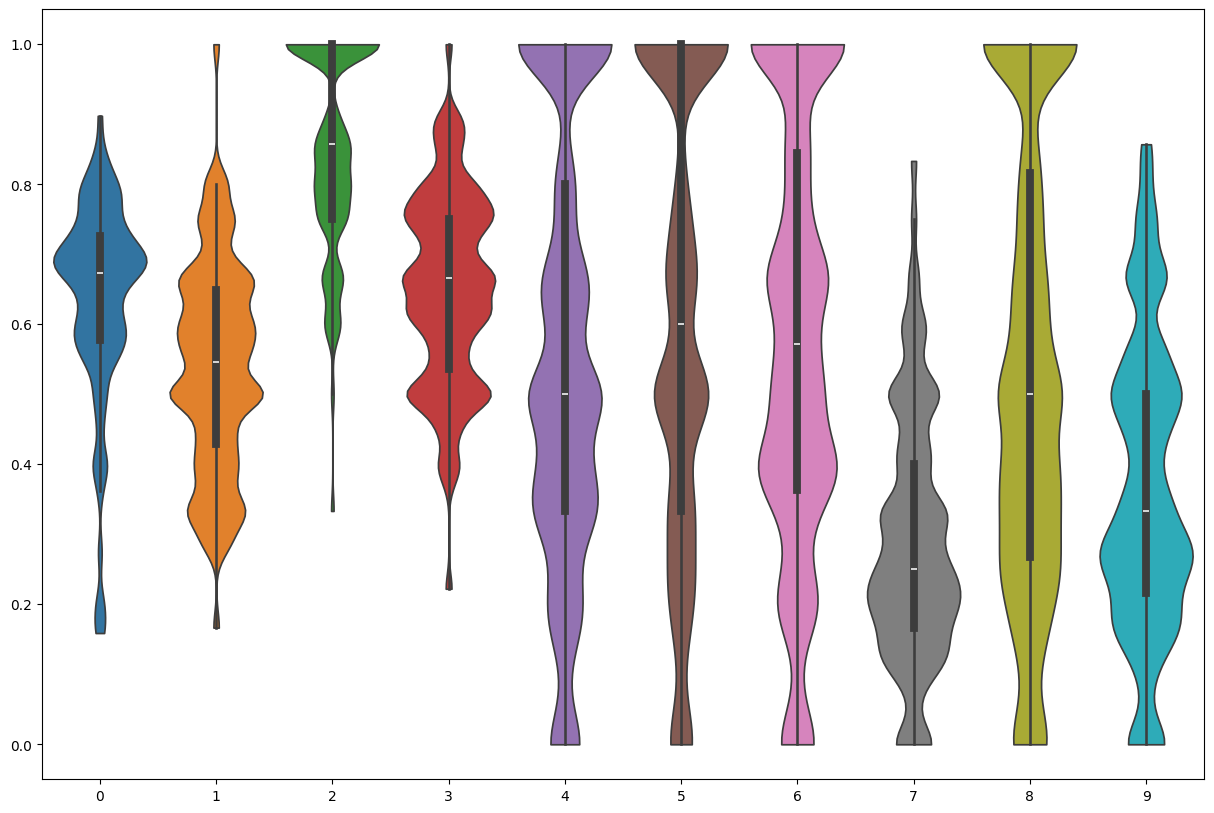

In [19]:
import time

#Dataset = "ArrowSynthTurns"
Dataset = "ArrowSynthShapesTP5"
SampleID = "081"
Predictor = "Symmetry"
#Predictor = "Kalman"

iou_threshold = 0.5

t0 = time.time()

TestSample = AllSampleFramewise.query("Dataset == @Dataset and SampleID == @SampleID")

TS_seg_iou = []
TS_seg_precision = []
TS_seg_recall = []
TS_seg_f_scores = []
TS_tr_precision = []
TS_tr_recall = []
TS_tr_f_scores = []
TS_tr_precision_legacy = []
TS_tr_recall_legacy = []
TS_tr_f_scores_legacy = []
#TS_MOTAs = []

for frame in TestSample["Frame"].unique():
    if frame >= max(TestSample["Frame"].unique()) or frame > 100:
        break

    gt_mask_0 = decompress_np_img_zlib(TestSample[TestSample["Frame"] == frame]["GroundTruth"].values[0]).astype(np.uint16)
    gt_mask_1 = decompress_np_img_zlib(TestSample[TestSample["Frame"] == frame+1]["GroundTruth"].values[0]).astype(np.uint16)
    pred_mask_0 = decompress_np_img_zlib(TestSample[TestSample["Frame"] == frame][f"Pred{Predictor}"].values[0]).astype(np.uint16)
    pred_mask_1 = decompress_np_img_zlib(TestSample[TestSample["Frame"] == frame+1][f"Pred{Predictor}"].values[0]).astype(np.uint16)

    """
    seg_iou = calculate_semantic_segmentation_iou(gt_mask_0, pred_mask_0)
    seg_f_score = calculate_segmentation_fscore(gt_mask_0, pred_mask_0)
    tr_f_score = calculate_tracking_fscore(gt_mask_0, gt_mask_1, pred_mask_0, pred_mask_1)

    try:
      rtr_pred_acc = calculate_region_tracking_pred_accuracy_gpu(gt_mask_0, gt_mask_1, pred_mask_0, pred_mask_1)
    except:
      rtr_pred_acc = np.nan
    """

    result_dict = calculate_all_iou_metrics(gt_mask_0, gt_mask_1, pred_mask_0, pred_mask_1, iou_threshold)

    TS_seg_iou.append(result_dict["Segmentation IOU"])
    TS_seg_precision.append(result_dict["Detection Precision"])
    TS_seg_recall.append(result_dict["Detection Recall"])
    TS_seg_f_scores.append(result_dict["Detection F-Score"])
    TS_tr_precision.append(result_dict["Association Precision"])
    TS_tr_recall.append(result_dict["Association Recall"])
    TS_tr_f_scores.append(result_dict["Association F-Score"])
    TS_tr_precision_legacy.append(result_dict["Association Precision Legacy"])
    TS_tr_recall_legacy.append(result_dict["Association Recall Legacy"])
    TS_tr_f_scores_legacy.append(result_dict["Association F-Score Legacy"])
    #TS_MOTAs.append(result_dict["MOTA"])

t1 = time.time()

print(f"Time: {t1-t0}")

print()

print("Segmentation IoU")
print(f"Mean: {np.mean(TS_seg_iou)}")
print(f"std: {np.std(TS_seg_iou)}")

print()

print("Segmentation Precision")
print(f"Mean: {np.mean(TS_seg_precision)}")
print(f"std: {np.std(TS_seg_precision)}")

print()

print("Segmentation Recall")
print(f"Mean: {np.mean(TS_seg_recall)}")
print(f"std: {np.std(TS_seg_recall)}")

print()

print("Segmentation F Score")
print(f"Mean: {np.mean(TS_seg_f_scores)}")
print(f"std: {np.std(TS_seg_f_scores)}")

print()

print("Tracking Precision")
print(f"Mean: {np.mean(TS_tr_precision)}")
print(f"std: {np.std(TS_tr_precision)}")

print()

print("Tracking Recall")
print(f"Mean: {np.mean(TS_tr_recall)}")
print(f"std: {np.std(TS_tr_recall)}")

print()

print("Tracking F Score")
print(f"Mean: {np.mean(TS_tr_f_scores)}")
print(f"std: {np.std(TS_tr_f_scores)}")

print()

print("Tracking Precision Legacy")
print(f"Mean: {np.mean(TS_tr_precision_legacy)}")
print(f"std: {np.std(TS_tr_precision_legacy)}")

print()

print("Tracking Recall Legacy")
print(f"Mean: {np.mean(TS_tr_recall_legacy)}")
print(f"std: {np.std(TS_tr_recall_legacy)}")

print()

print("Tracking F Score Legacy")

print(f"Mean: {np.mean(TS_tr_f_scores_legacy)}")
print(f"std: {np.std(TS_tr_f_scores_legacy)}")

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
sns.violinplot(data=[TS_seg_iou, TS_seg_precision, TS_seg_recall, TS_seg_f_scores, TS_tr_precision, TS_tr_recall, TS_tr_f_scores, TS_tr_precision_legacy, TS_tr_recall_legacy, TS_tr_f_scores_legacy],
               cut = 0,
               bw_method = 0.15)
plt.show()

# HOTA metrics

In [20]:
import motmetrics as mm
import numpy as np

def prepare_motmetrics_data(image_data, frame_id):
    """
    Prepares the data for motmetrics.

    Args:
        image_data (np.array): The 2D array representing objects with unique IDs (0 is the background).
        frame_id (int): The frame ID.

    Returns:
        A list of tuples (object_id, bbox).
    """
    objects = np.unique(image_data)
    objects = objects[objects != 0]  # Exclude background
    data = []

    for obj_id in objects:
        # Extract bounding box
        y, x = np.where(image_data == obj_id)
        if len(x) == 0 or len(y) == 0:
            continue

        x_min, x_max = np.min(x), np.max(x)
        y_min, y_max = np.min(y), np.max(y)

        bbox = [x_min, y_min, x_max - x_min + 1, y_max - y_min + 1]
        data.append((obj_id, bbox))

    return frame_id, data

def calculate_mota(gt_images, pred_images):
    """
    Calculates the MOTA metric for given GT and prediction images.

    Args:
        gt_images (list of np.array): List of GT images.
        pred_images (list of np.array): List of Prediction images.

    Returns:
        dict: Dictionary containing MOTA score.
    """
    acc = mm.MOTAccumulator(auto_id=True)

    for frame_id, (gt_image, pred_image) in enumerate(zip(gt_images, pred_images)):
        gt_frame_id, gt_data = prepare_motmetrics_data(gt_image, frame_id)
        pred_frame_id, pred_data = prepare_motmetrics_data(pred_image, frame_id)

        gt_ids = [d[0] for d in gt_data]
        gt_bboxes = [d[1] for d in gt_data]

        pred_ids = [d[0] for d in pred_data]
        pred_bboxes = [d[1] for d in pred_data]

        distances = mm.distances.iou_matrix(gt_bboxes, pred_bboxes, max_iou=0.5)

        acc.update(gt_ids, pred_ids, distances)

    metrics = mm.metrics.create()
    summary = metrics.compute(acc, metrics=['mota', 'motp'], return_dataframe=False)

    return summary

In [23]:
import numpy as np
import motmetrics as mm
import pandas as pd

def create_motchallenge_format(image_data, frame_id):
    """
    Converts an image with labeled objects to MOTChallenge format.

    Args:
        image_data (np.array): The 2D array representing objects with unique IDs (0 is the background).
        frame_id (int): The frame ID.

    Returns:
        pd.DataFrame: DataFrame in MOTChallenge format with columns ['FrameId', 'Id', 'X', 'Y', 'Width', 'Height'].
    """
    objects = np.unique(image_data)
    objects = objects[objects != 0]  # Exclude background
    data = []

    for obj_id in objects:
        # Extract bounding box
        y, x = np.where(image_data == obj_id)
        if len(x) == 0 or len(y) == 0:
            continue

        x_min, x_max = np.min(x), np.max(x)
        y_min, y_max = np.min(y), np.max(y)

        bbox = [x_min, y_min, x_max - x_min + 1, y_max - y_min + 1]
        data.append([frame_id, obj_id, bbox[0], bbox[1], bbox[2], bbox[3]])

    return pd.DataFrame(data, columns=['FrameId', 'Id', 'X', 'Y', 'Width', 'Height'])

def calculate_hota(gt_images, pred_images):
    """
    Computes the HOTA metric from ground truth and prediction images.

    Args:
        gt_images (list of np.array): List of ground truth images.
        pred_images (list of np.array): List of prediction images.

    Returns:
        str: Summary of HOTA metrics.
    """
    gt_data = []
    pred_data = []

    # Convert all images to DataFrame format
    for frame_id, (gt_image, pred_image) in enumerate(zip(gt_images, pred_images), start=1):
        gt_df = create_motchallenge_format(gt_image, frame_id)
        pred_df = create_motchallenge_format(pred_image, frame_id)

        gt_data.append(gt_df)
        pred_data.append(pred_df)

    # Combine data from all frames
    gt_df = pd.concat(gt_data, ignore_index=True)
    pred_df = pd.concat(pred_data, ignore_index=True)

    # Ensure no hierarchical indexing; DataFrames should be flat
    gt_df.reset_index(drop=True, inplace=True)
    pred_df.reset_index(drop=True, inplace=True)

    # Set the multi-index required for motmetrics
    gt_df.set_index(['FrameId', 'Id'], inplace=True)
    pred_df.set_index(['FrameId', 'Id'], inplace=True)

    # Create MOTAccumulator
    acc = mm.MOTAccumulator(auto_id=True)

    # Iterate over frames and accumulate the results
    frames = sorted(gt_df.index.get_level_values('FrameId').unique())
    for frame in frames:
        gt_frame = gt_df.loc[frame]
        pred_frame = pred_df.loc[frame]

        gt_ids = gt_frame.index.get_level_values('Id').values
        pred_ids = pred_frame.index.get_level_values('Id').values

        gt_bboxes = gt_frame[['X', 'Y', 'Width', 'Height']].values
        pred_bboxes = pred_frame[['X', 'Y', 'Width', 'Height']].values

        # Calculate IoU distance matrix
        distances = mm.distances.iou_matrix(gt_bboxes, pred_bboxes, max_iou=0.5)

        acc.update(gt_ids, pred_ids, distances)

    # Calculate the HOTA metric
    mh = mm.metrics.create()

    # Use multiple thresholds for the computation
    th_list = np.arange(0.05, 0.99, 0.05)
    res_list = mm.utils.compare_to_groundtruth_reweighting(gt_df, pred_df, "iou", distth=th_list)

    # Compute metrics
    summary = mh.compute_many(
        res_list,
        metrics=[
            "deta_alpha",
            "assa_alpha",
            "hota_alpha",
        ],
        generate_overall=True,  # `Overall` is the average we need only
    )

    return summary.iloc[-1]

Time: 28.776808261871338

DETAs
Mean: 0.4179639204529904
std: 0.09314366832044753
ASSAs
Mean: 0.657537923654541
std: 0.12430202891312123
HOTAs
Mean: 0.5098932202935829
std: 0.0882666974889479


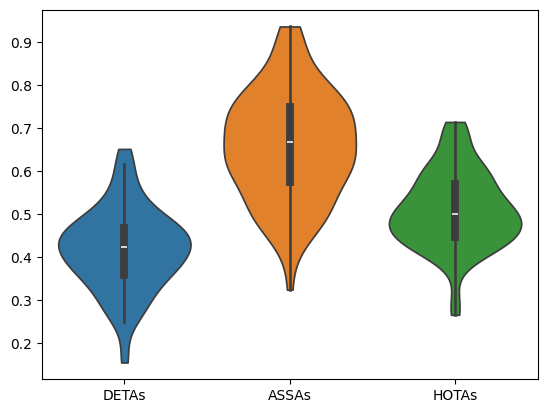

In [30]:
import time
import os

#Dataset = "ArrowSynthTurns"
Dataset = "ArrowSynthShapesTP5"
SampleID = "081"
Predictor = "Symmetry"
#Predictor = "Kalman"

t0 = time.time()

TestSample = AllSampleFramewise.query("Dataset == @Dataset and SampleID == @SampleID")

DETAs = []
ASSAs = []
HOTAs = []

for frame in TestSample["Frame"].unique():
    if frame >= max(TestSample["Frame"].unique()) or frame > 100:
        break

    gt_mask_0 = decompress_np_img_zlib(TestSample[TestSample["Frame"] == frame]["GroundTruth"].values[0]).astype(np.uint16)
    gt_mask_1 = decompress_np_img_zlib(TestSample[TestSample["Frame"] == frame+1]["GroundTruth"].values[0]).astype(np.uint16)
    pred_mask_0 = decompress_np_img_zlib(TestSample[TestSample["Frame"] == frame][f"Pred{Predictor}"].values[0]).astype(np.uint16)
    pred_mask_1 = decompress_np_img_zlib(TestSample[TestSample["Frame"] == frame+1][f"Pred{Predictor}"].values[0]).astype(np.uint16)

    hota_summary = calculate_hota([gt_mask_0, gt_mask_1], [pred_mask_0, pred_mask_1])

    HOTAs.append(hota_summary["hota_alpha"])
    ASSAs.append(hota_summary["assa_alpha"])
    DETAs.append(hota_summary["deta_alpha"])

t1 = time.time()

print(f"Time: {t1-t0}")

print()

print("DETAs")
print(f"Mean: {np.mean(DETAs)}")
print(f"std: {np.std(DETAs)}")

print("ASSAs")
print(f"Mean: {np.mean(ASSAs)}")
print(f"std: {np.std(ASSAs)}")

print("HOTAs")
print(f"Mean: {np.mean(HOTAs)}")
print(f"std: {np.std(HOTAs)}")

sns.violinplot(data = [DETAs, ASSAs, HOTAs], cut = 0)
plt.xticks([0, 1, 2], ["DETAs", "ASSAs", "HOTAs"])
plt.show()

# Combined full evaluation run and export

In [37]:
AllSampleFramewise = AllSampleFramewise[AllSampleFramewise["Dataset"].isin(["MOTS20"])]
AllSampleFramewise

,Dataset,SampleID,Frame,GroundTruth,SampleRatio,PredKalman,PredSymmetry,PredSymmetryL2,PredSymmetryShape,ValidSample
12000,MOTS20,02,0,b'\x80\x04\x959\x07\x00\x00\x00\x00\x00\x00M\x...,None,b'\x80\x04\x95\xa5\x04\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\x80\x05\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95)\x06\x00\x00\x00\x00\x00\x00M\x...,b'\x80\x04\x95\xd3\x06\x00\x00\x00\x00\x00\x00...,True
12001,MOTS20,02,1,b'\x80\x04\x950\x07\x00\x00\x00\x00\x00\x00M\x...,None,b'\x80\x04\x95\xaa\x05\x00\x00\x00\x00\x00\x00...,"b""\x80\x04\x95\xc1\x05\x00\x00\x00\x00\x00\x00...","b""\x80\x04\x95j\x06\x00\x00\x00\x00\x00\x00M\x...",b'\x80\x04\x95+\x07\x00\x00\x00\x00\x00\x00M\x...,True
12002,MOTS20,02,2,b'\x80\x04\x95G\x07\x00\x00\x00\x00\x00\x00M\x...,None,b'\x80\x04\x95_\x05\x00\x00\x00\x00\x00\x00M\x...,"b""\x80\x04\x95\x81\x05\x00\x00\x00\x00\x00\x00...","b""\x80\x04\x956\x06\x00\x00\x00\x00\x00\x00M\x...","b""\x80\x04\x95\xcf\x06\x00\x00\x00\x00\x00\x00...",True
12003,MOTS20,02,3,"b""\x80\x04\x95.\x07\x00\x00\x00\x00\x00\x00M\x...",None,"b""\x80\x04\x95n\x05\x00\x00\x00\x00\x00\x00M\x...","b""\x80\x04\x95^\x05\x00\x00\x00\x00\x00\x00M\x...",b'\x80\x04\x95\x00\x06\x00\x00\x00\x00\x00\x00...,"b""\x80\x04\x95\xb6\x06\x00\x00\x00\x00\x00\x00...",True
12004,MOTS20,02,4,"b""\x80\x04\x95=\x07\x00\x00\x00\x00\x00\x00M\x...",None,b'\x80\x04\x95\x93\x05\x00\x00\x00\x00\x00\x00...,"b""\x80\x04\x95\x9e\x05\x00\x00\x00\x00\x00\x00...",b'\x80\x04\x959\x06\x00\x00\x00\x00\x00\x00M\x...,b'\x80\x04\x95\xd8\x06\x00\x00\x00\x00\x00\x00...,True
...,...,...,...,...,...,...,...,...,...,...
14020,MOTS20,11,895,b'\x80\x04\x95\xd0\t\x00\x00\x00\x00\x00\x00M\...,None,b'\x80\x04\x95\x9b\x01\x00\x00\x00\x00\x00\x00...,"b""\x80\x04\x95\r\x05\x00\x00\x00\x00\x00\x00M\...","b""\x80\x04\x95\x0b\x04\x00\x00\x00\x00\x00\x00...","b""\x80\x04\x95\xec\x03\x00\x00\x00\x00\x00\x00...",True
14021,MOTS20,11,896,b'\x80\x04\x95\xbe\t\x00\x00\x00\x00\x00\x00M\...,None,b'\x80\x04\x95#\x01\x00\x00\x00\x00\x00\x00M\x...,b'\x80\x04\x95\xb0\x04\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\xb1\x04\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\xfa\x03\x00\x00\x00\x00\x00\x00...,True
14022,MOTS20,11,897,b'\x80\x04\x95\xce\t\x00\x00\x00\x00\x00\x00M\...,None,b'\x80\x04\x95#\x01\x00\x00\x00\x00\x00\x00M\x...,"b""\x80\x04\x95\x16\x04\x00\x00\x00\x00\x00\x00...","b""\x80\x04\x95\x17\x04\x00\x00\x00\x00\x00\x00...",b'\x80\x04\x95\xce\x03\x00\x00\x00\x00\x00\x00...,True
14023,MOTS20,11,898,b'\x80\x04\x95\x10\n\x00\x00\x00\x00\x00\x00M\...,None,b'\x80\x04\x95#\x01\x00\x00\x00\x00\x00\x00M\x...,"b""\x80\x04\x95\x18\x04\x00\x00\x00\x00\x00\x00...","b""\x80\x04\x95\x1a\x04\x00\x00\x00\x00\x00\x00...",b'\x80\x04\x95\xd4\x03\x00\x00\x00\x00\x00\x00...,True


In [ ]:
#@title Linear solution

import time
import pandas as pd

iou_threshold = 0.5

"""
SampleCount = AllSampleFramewise[
    AllSampleFramewise["Dataset"].isin(["ArrowSynth1", "ArrowSynthTurns", "ArrowSynthOcclusions", "MOTS20"])
].drop_duplicates(subset=["Dataset", "SampleID"]).shape[0]
"""

SampleCount = AllSampleFramewise.drop_duplicates(subset=["Dataset", "SampleID"]).shape[0]
SampleIterator = 0

results_df = pd.DataFrame(columns=["Dataset", "SampleID", "Frame", "Predictor", "MOTA", "MOTP", "DETA", "ASSA", "HOTA"])

#for Dataset in ["ArrowSynth1", "ArrowSynthTurns", "ArrowSynthOcclusions", "MOTS20"]:
for Dataset in AllSampleFramewise["Dataset"].unique():
    for SampleID in AllSampleFramewise[AllSampleFramewise["Dataset"] == Dataset]["SampleID"].unique():
        t0 = time.time()
        for Predictor in ["Kalman", "Symmetry", "SymmetryL2", "SymmetryShape"]:
            Sample = AllSampleFramewise.query("Dataset == @Dataset and SampleID == @SampleID")

            for frame in sorted(Sample["Frame"].unique())[:-1]:

                try:

                  gt_mask_0 = decompress_np_img_zlib(Sample[Sample["Frame"] == frame]["GroundTruth"].values[0]).astype(np.uint16)
                  gt_mask_1 = decompress_np_img_zlib(Sample[Sample["Frame"] == frame+1]["GroundTruth"].values[0]).astype(np.uint16)
                  pred_mask_0 = decompress_np_img_zlib(Sample[Sample["Frame"] == frame][f"Pred{Predictor}"].values[0]).astype(np.uint16)
                  pred_mask_1 = decompress_np_img_zlib(Sample[Sample["Frame"] == frame+1][f"Pred{Predictor}"].values[0]).astype(np.uint16)

                  result_dict = calculate_all_iou_metrics(gt_mask_0, gt_mask_1, pred_mask_0, pred_mask_1, iou_threshold)
                  mota_summary = calculate_mota([gt_mask_0, gt_mask_1], [pred_mask_0, pred_mask_1])
                  hota_summary = calculate_hota([gt_mask_0, gt_mask_1], [pred_mask_0, pred_mask_1])

                  result_dict["Dataset"] = Dataset
                  result_dict["SampleID"] = SampleID
                  result_dict["Frame"] = frame
                  result_dict["Predictor"] = Predictor

                  result_dict["MOTA"] = mota_summary["mota"]
                  result_dict["MOTP"] = mota_summary["motp"]

                  result_dict["DETA"] = hota_summary["deta_alpha"]
                  result_dict["ASSA"] = hota_summary["assa_alpha"]
                  result_dict["HOTA"] = hota_summary["hota_alpha"]

                  results_df = pd.concat([results_df, pd.DataFrame([result_dict])], ignore_index=True)

                except:

                  print(f"Frame {frame} skipped in analysis")

        SampleIterator += 1
        print(f"{Dataset:20}\t{SampleID}\t{int(SampleIterator/SampleCount*100)}%\t dt: {int(time.time()-t0)} sec\t remaining estimate: {int((time.time()-t0)*(SampleCount-SampleIterator)/60)} min")

display(results_df)

In [ ]:
#@title Parallel solution (not faster in this environment)

import concurrent.futures
import pandas as pd
import numpy as np
import time

iou_threshold = 0.5

def process_frame(frame, iou_threshold):

    gt_mask_0 = decompress_np_img_zlib(Sample[Sample["Frame"] == frame]["GroundTruth"].values[0]).astype(np.uint16)
    gt_mask_1 = decompress_np_img_zlib(Sample[Sample["Frame"] == frame+1]["GroundTruth"].values[0]).astype(np.uint16)
    pred_mask_0 = decompress_np_img_zlib(Sample[Sample["Frame"] == frame][f"Pred{Predictor}"].values[0]).astype(np.uint16)
    pred_mask_1 = decompress_np_img_zlib(Sample[Sample["Frame"] == frame+1][f"Pred{Predictor}"].values[0]).astype(np.uint16)

    result_dict = calculate_all_iou_metrics(gt_mask_0, gt_mask_1, pred_mask_0, pred_mask_1, iou_threshold)
    mota_summary = calculate_mota([gt_mask_0, gt_mask_1], [pred_mask_0, pred_mask_1])
    hota_summary = calculate_hota([gt_mask_0, gt_mask_1], [pred_mask_0, pred_mask_1])

    result_dict["Dataset"] = Dataset
    result_dict["SampleID"] = SampleID
    result_dict["Frame"] = frame
    result_dict["Predictor"] = Predictor

    result_dict["MOTA"] = mota_summary["mota"]
    result_dict["MOTP"] = mota_summary["motp"]

    result_dict["DETA"] = hota_summary["deta_alpha"]
    result_dict["ASSA"] = hota_summary["assa_alpha"]
    result_dict["HOTA"] = hota_summary["hota_alpha"]

    return result_dict

SampleCount = AllSampleFramewise.drop_duplicates(subset=["Dataset", "SampleID"]).shape[0]
SampleIterator = 0

results_df = pd.DataFrame(columns=["Dataset", "SampleID", "Frame", "Predictor", "MOTA", "MOTP", "DETA", "ASSA", "HOTA"])

for Dataset in AllSampleFramewise["Dataset"].unique():
    for SampleID in AllSampleFramewise[AllSampleFramewise["Dataset"] == Dataset]["SampleID"].unique():
        t0 = time.time()
        for Predictor in ["Kalman", "Symmetry", "SymmetryL2", "SymmetryShape"]:
            Sample = AllSampleFramewise.query("Dataset == @Dataset and SampleID == @SampleID")

            with concurrent.futures.ThreadPoolExecutor() as executor:
                results = list(executor.map(process_frame, sorted(Sample["Frame"].unique())[:-1], [iou_threshold]*len(sorted(Sample["Frame"].unique())[:-1])))

            for result in results:
                results_df = pd.concat([results_df, pd.DataFrame([result])], ignore_index=True)

        SampleIterator += 1
        print(f"{Dataset:20}\t{SampleID}\t{int(SampleIterator/SampleCount*100)}%\t dt: {int(time.time()-t0)} sec\t remaining estimate: {int((time.time()-t0)*(SampleCount-SampleIterator)/60)} min")

display(results_df)

In [39]:
# Optionally save the results to a CSV file
results_df.to_csv("metric_results.csv", index=False)
# Save the results to a pickle file
results_df.to_pickle("metric_results.pkl")

In [40]:
from google.colab import files
files.download('metric_results.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>